# Lab 4:  Data preprocessing

We explore the performance of several linear regression models on a real-world dataset, i.e. [MoneyBall](https://www.openml.org/d/41021). See the description on OpenML for more information. In short, this dataset captures performance data from baseball players. The regression task is to accurately predict the number of 'runs' each player can score, and understanding which are the most important factors.

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import seaborn as sns

In [2]:
# Download MoneyBall data from OpenML
moneyball = oml.datasets.get_dataset(41021)
# Get the pandas dataframe (default)
X, y, _, attribute_names = moneyball.get_data(target=moneyball.default_target_attribute)

## Exploratory analysis and visualization
First, we visually explore the data by visualizing the value distribution and the interaction between every other feature in a scatter matrix. We use the target feature as the color variable to see which features are correlated with the target.

For the plotting to work, however, we need to remove the categorical features (the first 2) and fill in the missing values. Let's find out which columns have missing values. This matches what we already saw on the OpenML page (https://www.openml.org/d/41021).

In [3]:
pd.isnull(X).any()

Team            False
League          False
Year            False
RA              False
W               False
OBP             False
SLG             False
BA              False
Playoffs        False
RankSeason       True
RankPlayoffs     True
G               False
OOBP             True
OSLG             True
dtype: bool

For this first quick visualization, we will simply impute the missing values using the median. Removing all instances with missing values is not really an option since some features have consistent missing values: we would have to remove a lot of data.

In [4]:
# Impute missing values with sklearn and rebuild the dataframe
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
X_clean_array = imputer.fit_transform(X[attribute_names[2:]]) # skip the first 2 features
# The imputer will return a numpy array. To plot it we make it a pandas dataframe again.
X_clean = pd.DataFrame(X_clean_array, columns = attribute_names[2:]) #

Next, we build the scatter matrix. We include the target column to see which features strongly correlate with the target, and also use the target value as the color to see which combinations of features correlate with the target.

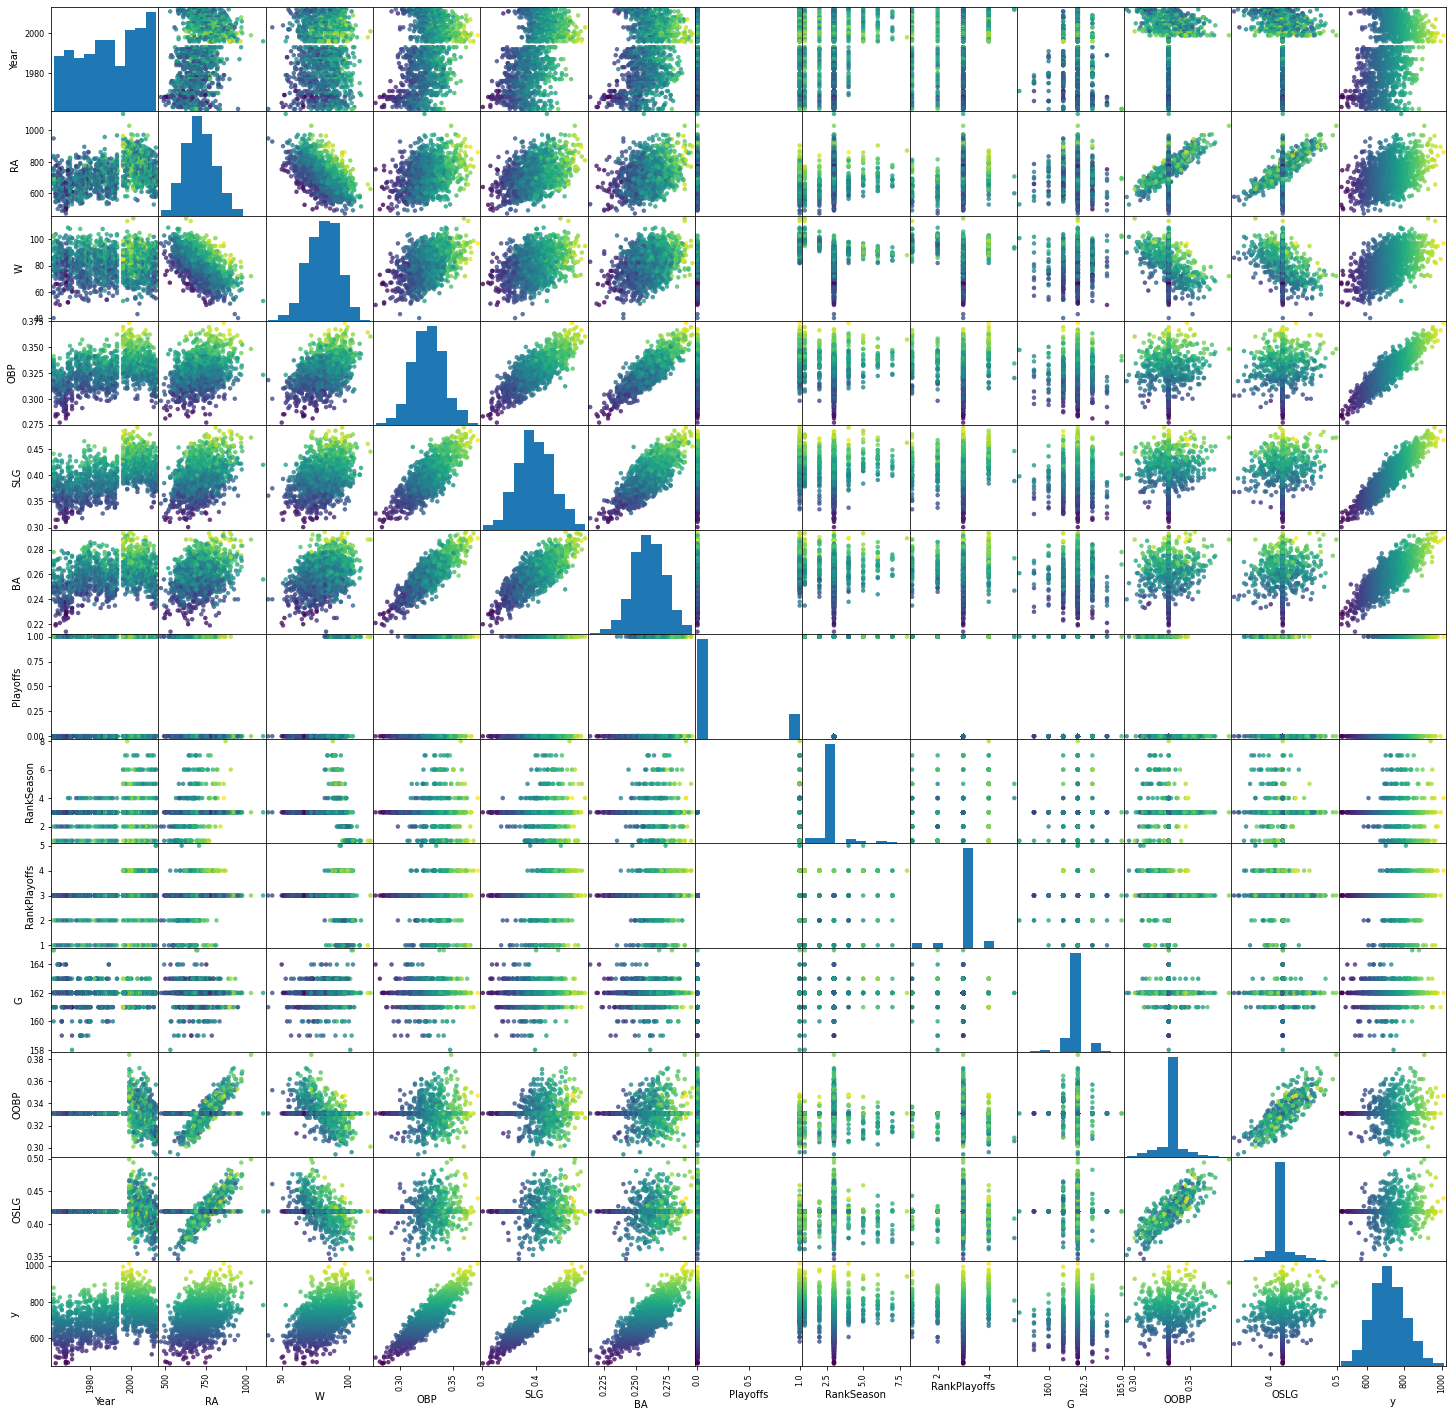

In [5]:
from pandas.plotting import scatter_matrix

# Scatter matrix of dataframe including the target feature
copyframe = X_clean.copy() 
copyframe['y'] = pd.Series(y, index=copyframe.index)
scatter_matrix(copyframe, c=y, figsize=(25,25), 
               marker='o', s=20, alpha=.8, cmap='viridis');

Several things immediately stand out:
* OBP, SLG and BA strongly correlate with the target (near-diagonals in the final column), but also combinations of either of these and W or R seem useful.
* RA, W, OBP, SLG and BA seem normally distributed, most others do not. 
* OOBP and OSLG have a very peaked distribution. 
* 'Playoffs' seems to be categorical and should probably be encoded as such. 

## Exercise 1: Build a pipeline

Implement a function `build_pipeline` that does the following:
- Impute missing values by replacing NaN's with the feature median for numerical features.
- Encode the categorical features using OneHotEncoding.
- If the attribute `scaling=True`, also scale the data using standard scaling.
- Attach the given regression model to the end of the pipeline

In [6]:
def build_pipeline(regressor, numerical, categorical, scaling=False):
    """ Build a robust pipeline with the given regression model
    Keyword arguments:
    regressor -- the regression model
    categorical -- the list of categorical features
    scaling -- whether or not to scale the data
    
    Returns: a pipeline
    """
    pass

## Exercise 2: Test the pipeline
Test the pipeline by evaluating linear regression (without scaling) on the dataset, using 5-fold cross-validation and $R^2$. Make sure to run it on the original dataset ('X'), not the manually cleaned version ('X_clean').

## Exercise 3: A first benchmark
Evaluate the following algorithms in their default settings, both with and without scaling, and interpret the results:  
- Linear regression
- Ridge
- Lasso
- SVM (RBF)
- RandomForests
- GradientBoosting

## Exercise 4: Tuning linear models
Next, visualize the effect of the alpha regularizer for Ridge and Lasso. Vary alpha from 1e-4 to 1e6 and plot the $R^2$ score as a line plot (one line for each algorithm). Always use scaling. Interpret the results.

## Exercise 5: Tuning SVMs
Next, tune the SVM's C and gamma. You can stay within the 1e-6 to 1e6 range. Plot the $R^2$ score as a heatmap.

In [7]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=None, vmax=None)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(), img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

## Exercise 5b: Tuning SVMs (2)
Redraw the heatmap, but now use scaling. What do you observe?

## Exercise 6: Feature importance 
Retrieve the coefficients from the optimized Lasso, Ridge, and the feature importances from the default RandomForest and GradientBoosting models.
Compare the results. Do the different models agree on which features are important? You will need to map the encoded feature names to the correct coefficients and feature importances. If you can, plot the importances as a bar chart.